In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, Flatten, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from keras.layers import MaxPooling1D

# Set random seed for reproducibility
np.random.seed(0)

# Define start and end dates
start_date = '1/1/2022'
end_date = pd.to_datetime('today')

# Define date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Define number of stores and items
n_stores = 3
n_items = 6

# Create a list of all combinations of dates, stores, and items
date_store_item_combinations = [(date, store, item) for date in date_range for store in range(1, n_stores+1) for item in range(1, n_items+1)]

# Define the number of rows to generate
n_rows = len(date_store_item_combinations)

# Unpack date, store, and item data
date_data, store_data, item_data = zip(*date_store_item_combinations)

# Generate random sales data
sales_data = np.random.randint(5, 26, size=n_rows)

# Create DataFrame with data
df = pd.DataFrame({'Date': date_data, 'Store': store_data, 'Item': item_data, 'Sales': sales_data})

# Format 'Date' column
df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%-m-%-d-%Y')

# Preprocess the data
sales_data = df['Sales'].values
sales_data = sales_data.astype('float32')
sales_data = np.reshape(sales_data, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
sales_data = scaler.fit_transform(sales_data)

# Split data into training set and test set
train_size = int(len(sales_data) * 0.70)
test_size = len(sales_data) - train_size
train, test = sales_data[0:train_size,:], sales_data[train_size:len(sales_data),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

# Reshape into X=t and Y=t+1
look_back = 14
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Create ConvLSTM model
model = Sequential()

# Add a 1D Convolutional layer to extract features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# Add LSTM layer
model.add(LSTM(100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=20, batch_size=1, verbose=2)


# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions back to prescaled values
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate root mean squared error
train_score = math.sqrt(mean_squared_error(Y_train[0], train_predict[:,0]))
print('Train Score: %.2f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print('Test Score: %.2f RMSE' % (test_score))

# Shift train predictions for plotting
train_predict_plot = np.empty_like(sales_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

# Shift test predictions for plotting
test_predict_plot = np.empty_like(sales_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(sales_data)-1, :] = test_predict



Epoch 1/20
6902/6902 - 30s - loss: 0.0965 - 30s/epoch - 4ms/step
Epoch 2/20
6902/6902 - 24s - loss: 0.0933 - 24s/epoch - 3ms/step
Epoch 3/20
6902/6902 - 24s - loss: 0.0933 - 24s/epoch - 3ms/step
Epoch 4/20
6902/6902 - 25s - loss: 0.0927 - 25s/epoch - 4ms/step
Epoch 5/20
6902/6902 - 25s - loss: 0.0927 - 25s/epoch - 4ms/step
Epoch 6/20
6902/6902 - 25s - loss: 0.0924 - 25s/epoch - 4ms/step
Epoch 7/20
6902/6902 - 25s - loss: 0.0923 - 25s/epoch - 4ms/step
Epoch 8/20
6902/6902 - 26s - loss: 0.0922 - 26s/epoch - 4ms/step
Epoch 9/20
6902/6902 - 26s - loss: 0.0923 - 26s/epoch - 4ms/step
Epoch 10/20
6902/6902 - 26s - loss: 0.0921 - 26s/epoch - 4ms/step
Epoch 11/20
6902/6902 - 26s - loss: 0.0921 - 26s/epoch - 4ms/step
Epoch 12/20
6902/6902 - 26s - loss: 0.0921 - 26s/epoch - 4ms/step
Epoch 13/20
6902/6902 - 27s - loss: 0.0920 - 27s/epoch - 4ms/step
Epoch 14/20
6902/6902 - 26s - loss: 0.0920 - 26s/epoch - 4ms/step
Epoch 15/20
6902/6902 - 26s - loss: 0.0918 - 26s/epoch - 4ms/step
Epoch 16/20
6902/69

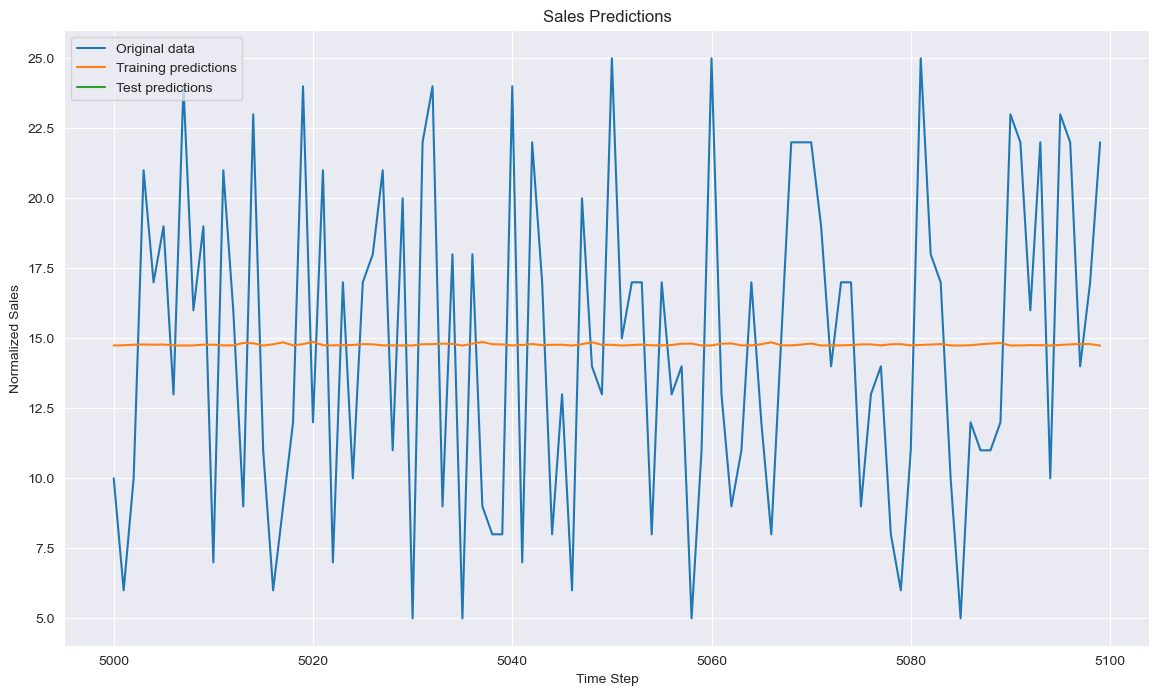

In [23]:
# Define the range of data to be plotted
start_index = 5000
end_index = 5100

# Plot baseline and predictions
plt.figure(figsize=(14, 8))  # optional, to adjust the figure size
plt.plot(range(start_index, end_index), scaler.inverse_transform(sales_data[start_index:end_index]), label='Original data')
plt.plot(range(start_index, end_index), train_predict_plot[start_index:end_index], label='Training predictions')
plt.plot(range(start_index, end_index), test_predict_plot[start_index:end_index], label='Test predictions')
plt.title('Sales Predictions')
plt.xlabel('Time Step')
plt.ylabel('Normalized Sales')
plt.legend(loc='upper left')
plt.show()

In [24]:
display(df[-100:])

,Date,Store,Item,Sales
9782,2023-06-28 00:00:00,2,3,13
9783,2023-06-28 00:00:00,2,4,22
9784,2023-06-28 00:00:00,2,5,22
9785,2023-06-28 00:00:00,2,6,20
9786,2023-06-28 00:00:00,3,1,16
...,...,...,...,...
9877,2023-07-03 00:00:00,3,2,19
9878,2023-07-03 00:00:00,3,3,6
9879,2023-07-03 00:00:00,3,4,17
9880,2023-07-03 00:00:00,3,5,25


In [17]:
# Display last 100 records of date, actual data, predicted values
df_results = pd.DataFrame({
    'Date': df['Date'][-len(test_predict):][-100:],
    'Actual Sales': scaler.inverse_transform(test)[-100:].flatten(),
    'Predicted Sales': test_predict[-100:].flatten()
})

# Display the DataFrame
display(df_results)

,Date,Actual Sales,Predicted Sales
9782,2023-06-28 00:00:00,13.000001,14.832503
9783,2023-06-28 00:00:00,22.000000,14.843027
9784,2023-06-28 00:00:00,22.000000,14.747144
9785,2023-06-28 00:00:00,20.000000,14.748125
9786,2023-06-28 00:00:00,16.000000,14.754777
...,...,...,...
9877,2023-07-03 00:00:00,19.000000,14.753574
9878,2023-07-03 00:00:00,6.000000,14.759056
9879,2023-07-03 00:00:00,17.000000,14.750166
9880,2023-07-03 00:00:00,25.000000,14.748073
